<center> <h1>mIA-X 8ª Edición</h1> </center>

<center> <h1>Práctica 9 - Modelos Generativos</h1> </center>

<center> <h1>Javier Langeber Gavilán</h1> </center>

<center> <h1>Ejercicio 2</h1> </center>

---

## Queréis hacer un sistema de búsqueda por similitud. Tenéis un dataset (FashionMNIST train) sobre el que podéis entrenar o calcular cosas. Ahora tenéis un dato arbitrario de input (imagen "query", cogida de FashionMNIST test) del cual queréis encontrar otro existente dentro de una base de datos (FashionMNIST test, sin la imagen "query") lo más similar posible al dato de input. Desarrolla el sistema y evalúa cualitativamente con ejemplos de su funcionamiento.

## 1. Carga de librerías

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as kt
from keras.datasets import fashion_mnist
from keras.layers import Lambda, Input
from keras.models import Model
from keras.layers import Layer
import tensorflow as tf
from keras.layers.rnn.base_conv_rnn import InputSpec
from keras.layers import Dense, Flatten, Reshape, Input
from keras.models import Sequential, Model
from keras.losses import MSE

## 2. Obtención y preparación de datos

Se normalizan los datos, y se realiza una prueba de la visualización

In [3]:
(x_train_or, y_train), (x_test_or, y_test) = fashion_mnist.load_data()
x_train = ((x_train_or / 255) - 0.5) * 2
x_test = ((x_test_or / 255) - 0.5) * 2

In [4]:
plt.set_cmap("gray")

<Figure size 640x480 with 0 Axes>

(-0.5, 27.5, 27.5, -0.5)

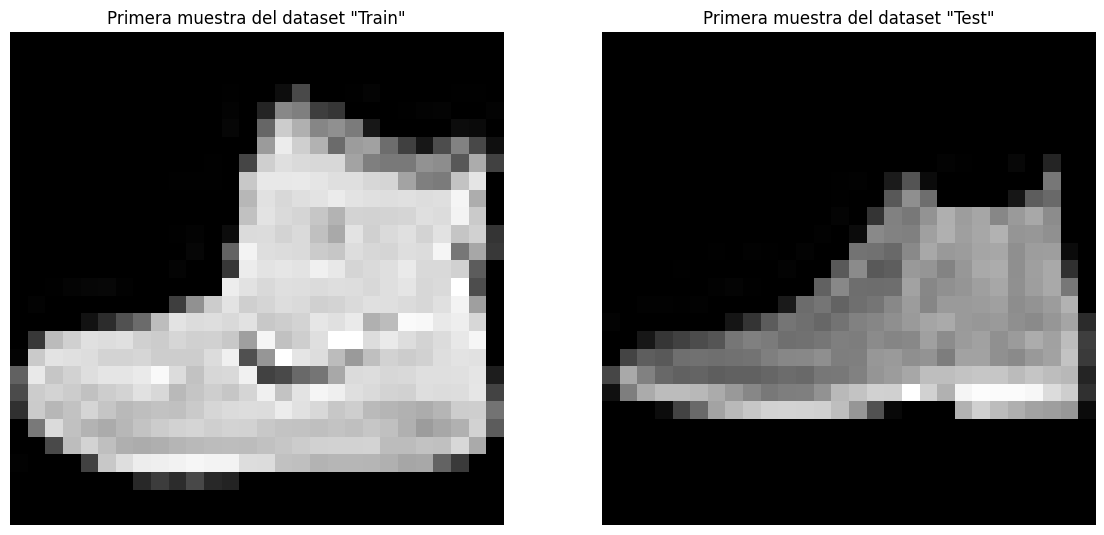

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
ax1.imshow(x_train[0])
ax1.title.set_text('Primera muestra del dataset "Train"')
ax1.axis('off')
ax2.imshow(x_test[0])
ax2.title.set_text('Primera muestra del dataset "Test"')
ax2.axis('off')

## 3. Generación de un VAE

### 3.1. Generación de capa de Sampling.

La capa de sampling permitirá obtener los paráemtros de una distribución normal que se ajusten a una serie de datos de entrada.

In [37]:
class Sampling(Layer):

  def __init__(self):
    super(Sampling, self).__init__()

  def call(self, inputs):
    mu, logstd = inputs
    std = tf.exp(logstd)
    epsilon = tf.random.normal(tf.shape(mu))
    return epsilon * std + mu

In [38]:
mu = Input(shape=2)
logstd = Input(shape=2)
sample = Sampling()([mu, logstd])
sampling_mod = Model([mu, logstd], sample)

### 3.2. Generación de la capa KL.

La capa KL permitirá computar el parecido entre 2 distribuciones.

In [61]:
class KL(Layer):

  def __init__(self, beta=1):
    self.beta = beta
    super(KL, self).__init__()
    

  def call(self, inputs):
    mu, logstd = inputs 
    kl_loss = 0.5 * (tf.square(mu) + tf.exp(logstd * 2.) - 1 - logstd * 2.)
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    self.add_loss(kl_loss)
    return inputs

In [62]:
mu = Input(shape = 2)
logstd = Input(shape = 2)
mu2, logstd2 = KL()([mu, logstd])
kl_model = Model([mu, logstd], [mu2, logstd2])

Se compila un modelo con la capa KL

In [63]:
kl_model.compile()

### 3.3. Generación del Autoencoder.

El autoencoder consiste en un modelo capaz de obtener las componentes principales del espacio latente de unos datos de entrada con conversiones no lineales. El método más sencillo para obtener esas componentes principales no lineales es mediante la utilización de una red neuronal. Un modo sencillo de entrenar esa red neuronal es generar otra red inmediatamente después que realice el proceso contrario, generando las muestras originales a partir de las componentes principales. 

La primera red tiene se denomina "encoder", y obtiene las componentes principales no lineales.

La segunda red se denomina "decoder", y reconstruye los datos originales

La unión de las 2 redes genera un Autoencoder, que es una red capaz de obtener las componentes principales no lineales de unos datos de entrada, y tras ello, reconstruir esos datos de entrada. Si la entrada al decoder se realiza utilizando una función de distribución, se compila una variante de autoencoder conocida como Variational AutoEncoder (VAE)

Para poder definir el autoencoder, hay que definir previamente las dimensiones del espacio latente (y de un espacio intermedio, para que el salto no sea muy brusco).


 ``z_dim`` hace referencia a las dimensiones del espacio latente, y ``h_dim`` a las dimensiones del espacio intermedio


In [64]:
z_dim = 100
h_dim = 200

#### 3.3.1. Generación del Encoder

In [65]:
encoder_head = Sequential([
    Flatten(input_shape = (28,28)),
    Dense(h_dim, activation = 'relu'),
])

inp = Input((28,28))
h = encoder_head(inp)
mu = Dense(z_dim)(h)
logstd = Dense(z_dim)(h)


# KL Layer
muout, logstdout = KL()([mu, logstd])

# Sampling Layer
z = Sampling()([muout,logstdout])

In [66]:
encoder_mean = Model(inp, mu)
encoder_sample = Model(inp, z)

In [67]:
encoder_sample.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, 200)          157000      ['input_12[0][0]']               
                                                                                                  
 dense_6 (Dense)                (None, 100)          20100       ['sequential_3[0][0]']           
                                                                                                  
 dense_7 (Dense)                (None, 100)          20100       ['sequential_3[0][0]']           
                                                                                            

#### 3.3.2. Generación del Decoder

In [69]:
decoder = Sequential([
    Dense(h_dim, activation='relu', input_shape = (z_dim,)),
    Dense(28*28, activation='tanh'),
    Reshape((28,28))
])

#### 3.3.3. Generación del Variational AutoEncoder

In [70]:
vae = Sequential([encoder_mean, decoder])

Se prueba el VAE antes de entrenarlo

In [72]:
def reconstruct_image(img):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
    ax1.imshow(x_train[img])
    ax1.title.set_text('Imagen original')
    ax1.axis('off')
    ax2.imshow(vae.predict(x_train[img:img+1])[0])
    ax2.title.set_text('Imagen reconstruida')
    ax2.axis('off')
    return

1/1 [==============================] - 0s 18ms/step


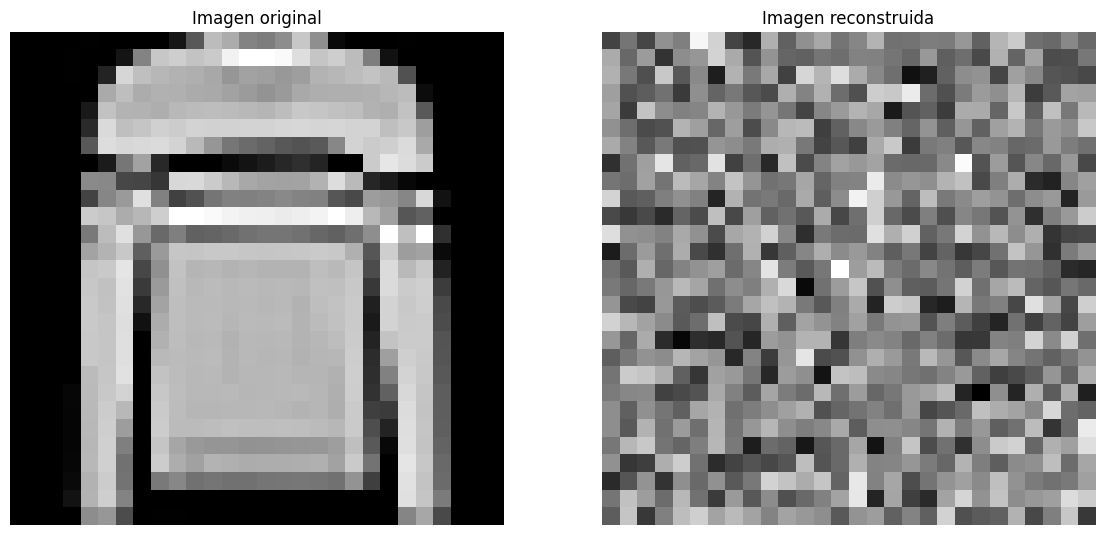

In [73]:
reconstruct_image(5)

Como se puede ver, por ahora el VAE deja un poco que desear. A continuación se compila, entrena y se vuelve a probar.

In [74]:
vae.compile(optimizer = 'adam', loss=lambda x,y: MSE(x,y)*28*28)

In [75]:
n_epochs = 60
batch_size = 128
history = vae.fit(x_train, x_train, validation_data = (x_test, x_test), batch_size=batch_size, epochs=n_epochs)

Epoch 1/60
469/469 [==============================] - 3s 6ms/step - loss: 66.0087 - val_loss: 38.2455
Epoch 2/60
469/469 [==============================] - 2s 5ms/step - loss: 33.4133 - val_loss: 30.3914
Epoch 3/60
469/469 [==============================] - 2s 5ms/step - loss: 28.0668 - val_loss: 26.5685
Epoch 4/60
469/469 [==============================] - 2s 5ms/step - loss: 25.3190 - val_loss: 24.6770
Epoch 5/60
469/469 [==============================] - 2s 5ms/step - loss: 23.5038 - val_loss: 23.1208
Epoch 6/60
469/469 [==============================] - 2s 5ms/step - loss: 22.2232 - val_loss: 21.9972
Epoch 7/60
469/469 [==============================] - 2s 5ms/step - loss: 21.3007 - val_loss: 21.3294
Epoch 8/60
469/469 [==============================] - 2s 5ms/step - loss: 20.5816 - val_loss: 20.8235
Epoch 9/60
469/469 [==============================] - 2s 5ms/step - loss: 20.0292 - val_loss: 20.3070
Epoch 10/60
469/469 [==============================] - 2s 5ms/step - loss: 19.5465

Antes de probarlo, se muestra una imagen de la evolución del Loss para cerciorar que ha llegado a un estado estacionario, y el modelo está entrenado

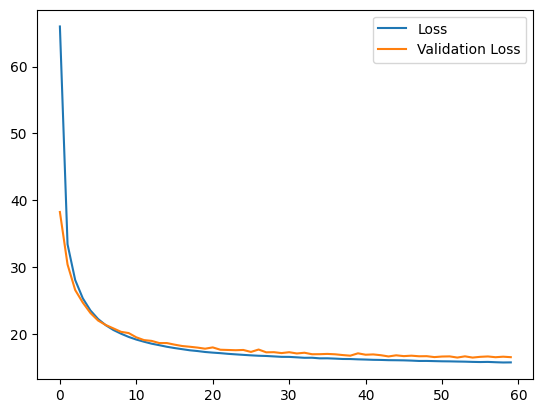

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

A continuación, se vuelve a probar el VAE con la misma imagen

1/1 [==============================] - 0s 86ms/step


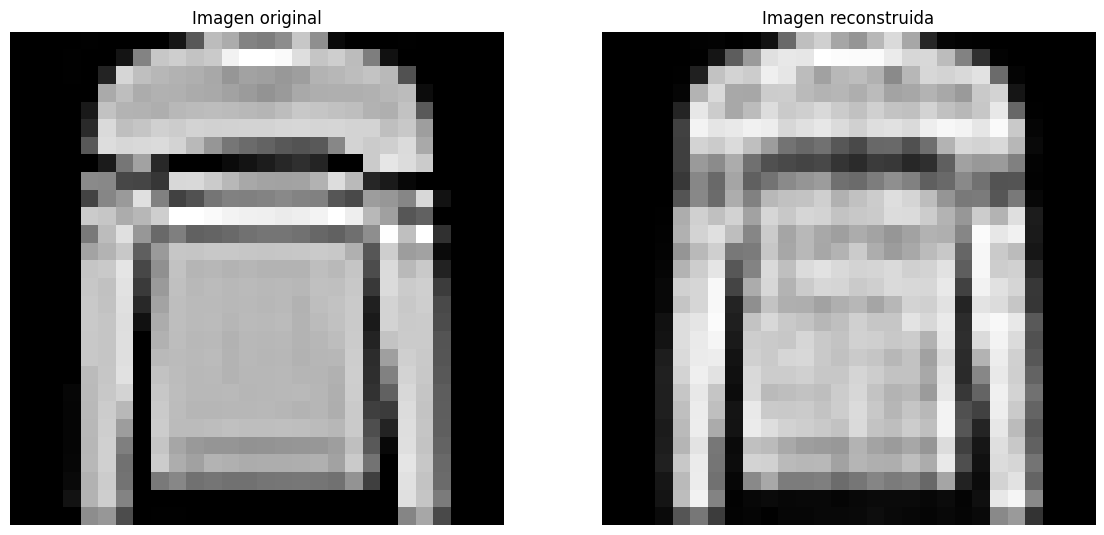

In [77]:
reconstruct_image(5)

Como se puede ver, ahora funciona mucho mejor

## 4. Generación dle motor de búsqueda por similitud

Por úlitmo, se desarrolla el código generado para buscar muestras similares en el dataset "Train" a una muestra de referencia obtenida desde el dataset "Test"

En primer lugar, se obtiene un vector ('database') donde se almacenan las componentes principales de todas las muestras del dataaset "Train"

In [96]:
database = encoder_mean.predict(x_train)

1875/1875 [==============================] - 2s 1ms/step


A continuación, se introduce la imagen deseada "query_image" en el encoder para obtener sus componentes en el espacio latente. Con esto se llega a una situación en la que, por una parte, se tiene un vector de vectores multidemnsionales, y por otra parte, un único vector multidimensional.

Para encontrar las imágenes más parecidas, lo único que hay que hacer es encontrar los vectores más cercanos dentro del dataset de vectores de "Train" al vector "query"

In [117]:
def search_image(query_image_num, i):
    pca_image = encoder_mean.predict(x_test[query_image_num:(query_image_num+1)])
    distances = np.sum(np.square(database - pca_image), axis=-1)
    sorted_indices = np.argsort(distances)
    image = x_train[sorted_indices[i]].reshape(28,28,1)
    similarity = distances[sorted_indices[i]]
    return image

In [120]:
def search_similar(query_image, search_num):
    for i in range(0,search_num+1):
        if i == 0:
            plt.imshow(x_test[query_image])
            plt.axis('off')
            plt.title(f'Query Image')
            plt.show()
        else:
            plt.imshow(search_image(query_image, i-1))
            plt.axis('off')
            plt.title(f'Similar Image number {i}')
            plt.show()

Por ejemplo, para la imágen 425, se obtienen las 5 prendas más parecidas

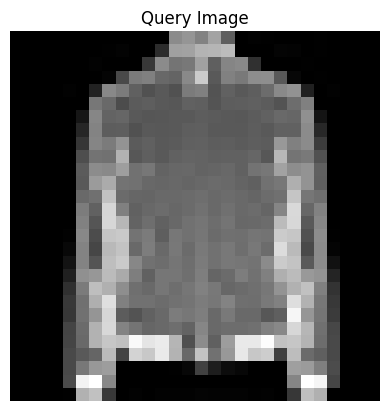

1/1 [==============================] - 0s 20ms/step


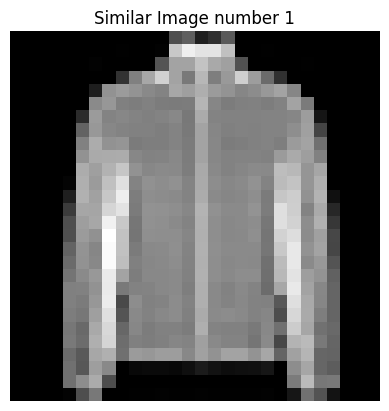

1/1 [==============================] - 0s 18ms/step


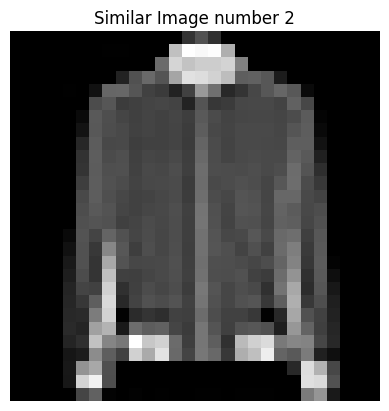

1/1 [==============================] - 0s 18ms/step


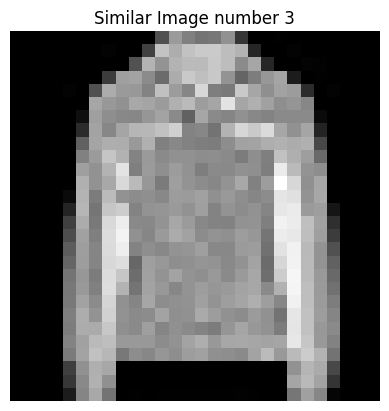

1/1 [==============================] - 0s 20ms/step


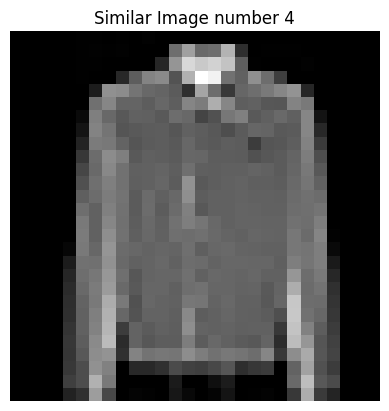

1/1 [==============================] - 0s 19ms/step


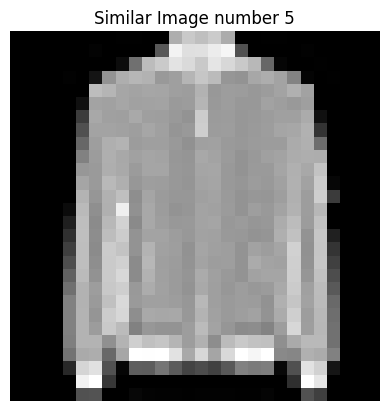

In [123]:
search_similar(query_image = 425, search_num = 5)

Como se puede apreciar, el motor funciona satisfactoriamente. Además, como es lógico, las primeras prendas se parecen más a la imagen query que las úlitmas